In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import re
import shutil
import pandas as pd
import scipy.stats
import scipy
from functools import reduce
import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import spatial_maps as sp
import head_direction.head as head
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import violinplot, despine, savefig
from spatial_maps.fields import find_peaks, calculate_field_centers, separate_fields_by_laplace
from spike_statistics.core import permutation_resampling_test, block_bootstrap
import speed_cells.speed as spd
from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

19:25:44 [I] klustakwik KlustaKwik2 version 0.2.6
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


In [3]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "longitudinal-comparisons"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

In [5]:
results = {}
results_change = {}
results_allcells = {}

for path in (output_path / 'data' / 'results_change').iterdir():
    if not path.is_dir():
        continue
    results_change[path.stem] = {}
    for cpath in path.iterdir():
        results_change[path.stem][cpath.stem] = pd.read_csv(cpath, index_col='Unnamed: 0')
    
for path in (output_path / 'data' / 'results_all_cells').iterdir():
    if not path.is_dir():
        continue
    results_allcells[path.stem] = {}
    for cpath in path.iterdir():
        results_allcells[path.stem][cpath.stem] = pd.read_csv(cpath, index_col='Unnamed: 0')
    
for path in (output_path / 'data' / 'results_unique_cells').iterdir():
    if not path.is_dir():
        continue
    results[path.stem] = {}
    for cpath in path.iterdir():
        results[path.stem][cpath.stem] = pd.read_csv(cpath, index_col='Unnamed: 0')

# Statistics

In [6]:
from septum_mec.analysis.statistics import bootstrap_results, make_bootstrap_table, make_paired_table

In [7]:
labels = results_change['gridcell']['gridness'].columns.drop(['entity', 'date']).tolist()

bootstrapped_results = {}

for cell_type in results_change:
    bootstrapped_results[cell_type] = bootstrap_results(results_change[cell_type], labels)

In [12]:
stats = {}
stats_values = {}
for cell_type, vals in bootstrapped_results.items():
    stats[cell_type], stats_values[cell_type] = make_bootstrap_table(results_change[cell_type], vals, labels)

/home/mikkel/apps/expipe-project/septum-mec/septum_mec/analysis/statistics.py:112: RuntimeWarning: invalid value encountered in subtract
  variance = np.average((values - average)**2, weights=weights)


In [13]:
stats['gridcell']

,Gridness,Max rate,Xcorr displacement,Xcorr cntr mass,Speed score,Average rate
Baseline Ia - Baseline Ib,6.0e-02 ± 3.7e-02 (63),-1.1e-02 ± 2.9e-02 (62),NaN,2.2e-02 ± 1.3e-03 (61),4.7e-02 ± 1.6e-02 (63),-2.3e-02 ± 4.0e-02 (63)
Baseline I - 11 Hz,-3.8e-01 ± 1.2e-01 (21),-2.1e-01 ± 6.3e-02 (21),NaN,2.2e-02 ± 2.3e-03 (19),-1.2e-02 ± 1.7e-02 (21),-2.0e-01 ± 8.3e-02 (21)
Baseline IIa - Baseline IIb,2.7e-01 ± 7.1e-02 (46),-inf ± nan (46),NaN,1.9e-02 ± 7.5e-05 (43),-1.6e-03 ± 1.9e-02 (46),-2.9e-02 ± 4.2e-02 (46)
Baseline II - 30 Hz,-2.6e-02 ± 8.6e-02 (16),-2.9e-02 ± 6.9e-02 (16),NaN,1.9e-02 ± 3.2e-03 (13),2.1e-02 ± 1.2e-02 (16),2.2e-02 ± 5.1e-02 (16)
Baseline I - Baseline II,-6.9e-02 ± 1.2e-01 (15),-1.2e-01 ± 6.7e-02 (15),NaN,2.0e-02 ± 2.5e-03 (14),-3.3e-02 ± 1.5e-02 (15),-8.7e-02 ± 1.1e-01 (15)
Baseline Ia - Baseline Ib - Baseline I - 11 Hz,"7.0e-02 [-2.9e-02, 9.6e-01]","1.0e-01 [-6.0e-02, 4.2e-01]",NaN,"9.0e-01 [-8.7e-03, 7.3e-03]","5.0e-02 [5.2e-03, 1.3e-01]","3.5e-01 [-1.7e-01, 5.8e-01]"
Baseline Ia - Baseline Ib - Baseline IIa - Baseline IIb,"3.8e-01 [-6.9e-01, 1.1e-01]","0.0e+00 [-4.4e-02, inf]",NaN,"0.0e+00 [3.1e-03, 3.6e-03]","4.4e-01 [-5.4e-02, 1.5e-01]","9.9e-01 [-1.6e-01, 2.0e-01]"
Baseline Ia - Baseline Ib - Baseline II - 30 Hz,"4.6e-01 [-1.8e-01, 2.4e-01]","9.1e-01 [-1.8e-01, 2.4e-01]",NaN,"3.9e-01 [-4.1e-03, 1.1e-02]","7.0e-02 [-6.9e-03, 5.1e-02]","5.9e-01 [-2.1e-01, 1.1e-01]"
Baseline Ia - Baseline Ib - Baseline I - Baseline II,"1.5e-01 [-3.5e-02, 3.3e-01]","2.0e-02 [3.8e-02, 1.9e-01]",NaN,"6.2e-01 [-5.7e-03, 9.6e-03]","0.0e+00 [4.7e-02, 1.2e-01]","5.5e-01 [-9.6e-02, 3.8e-01]"
Baseline I - 11 Hz - Baseline IIa - Baseline IIb,"1.0e-02 [-1.1e+00, -3.2e-01]","0.0e+00 [-2.4e-01, inf]",NaN,"0.0e+00 [2.7e-03, 3.3e-03]","9.1e-01 [-1.1e-01, 8.8e-02]","7.0e-02 [-3.3e-01, 2.6e-02]"


In [14]:
for cell_type, stat in stats.items():
    stat.to_latex(output_path / "statistics" / f"statistics_{cell_type}.tex")
    stat.to_csv(output_path / "statistics" / f"statistics_{cell_type}.csv")

In [24]:
paired_stats = {}
paired_stats_values = {}
for cell_type, cell_results in results_change.items():
    paired_stats[cell_type], paired_stats_values[cell_type] = make_paired_table(cell_results, labels)

In [25]:
paired_stats['gridcell']

,Gridness,Max rate,Xcorr displacement,Xcorr cntr mass,Speed score,Average rate
Normality Baseline Ia - Baseline Ib,"7.2e+00, 2.7e-02","1.5e+01, 5.6e-04",NaN,"1.3e+02, 6.1e-30","3.8e+01, 6.4e-09","5.7e+01, 4.6e-13"
Normality Baseline I - 11 Hz,"1.6e+00, 4.4e-01","2.2e+00, 3.4e-01",NaN,"2.1e+00, 3.6e-01","2.0e+00, 3.8e-01","4.6e+00, 1.0e-01"
Normality Baseline IIa - Baseline IIb,"7.3e+00, 2.6e-02",NaN,NaN,"2.6e+00, 2.7e-01","4.1e-01, 8.1e-01","5.0e+01, 1.3e-11"
Normality Baseline II - 30 Hz,"3.5e-01, 8.4e-01","8.2e-03, 1.0e+00",NaN,"1.6e+00, 4.5e-01","5.3e+00, 7.1e-02","2.1e+00, 3.5e-01"
Normality Baseline I - Baseline II,"5.8e+00, 5.5e-02","3.1e+00, 2.1e-01",NaN,"2.0e+00, 3.6e-01","8.1e-01, 6.7e-01","2.3e+01, 8.7e-06"
Wilcoxon Baseline Ia - Baseline Ib - Baseline I - 11 Hz,"9.4e+01, 4.5e-01, (21)","1.1e+02, 7.9e-01, (21)",NaN,"6.3e+01, 6.8e-02, (21)","1.0e+02, 6.9e-01, (21)","7.3e+01, 1.4e-01, (21)"
Wilcoxon Baseline Ia - Baseline Ib - Baseline IIa - Baseline IIb,"1.2e+01, 6.4e-03, (15)","3.3e+01, 1.3e-01, (15)",NaN,"5.0e+01, 5.7e-01, (15)","4.9e+01, 5.3e-01, (15)","3.4e+01, 1.4e-01, (15)"
Wilcoxon Baseline Ia - Baseline Ib - Baseline II - 30 Hz,"3.0e+00, 2.2e-01, (5)","7.0e+00, 8.9e-01, (5)",NaN,"4.0e+00, 3.5e-01, (5)","7.0e+00, 8.9e-01, (5)","5.0e+00, 5.0e-01, (5)"
Wilcoxon Baseline Ia - Baseline Ib - Baseline I - Baseline II,"4.7e+01, 4.6e-01, (15)","2.6e+01, 5.3e-02, (15)",NaN,"1.7e+01, 1.5e-02, (15)","5.5e+01, 7.8e-01, (15)","2.8e+01, 6.9e-02, (15)"
Wilcoxon Baseline I - 11 Hz - Baseline IIa - Baseline IIb,"2.2e+01, 9.5e-01, (9)","2.2e+01, 9.5e-01, (9)",NaN,"1.2e+01, 2.1e-01, (9)","1.9e+01, 6.8e-01, (9)","1.4e+01, 3.1e-01, (9)"


In [26]:
for cell_type, paired_stat in paired_stats.items():
    paired_stat.to_latex(output_path / "statistics" / f"paired-statistics_{cell_type}.tex")
    paired_stat.to_csv(output_path / "statistics" / f"paired-statistics_{cell_type}.csv")

# Plotting distributions

In [220]:
comparison_key_val = {
    'Baseline Ia - Baseline Ib':'',
    'Baseline I - 11 Hz': 'Baseline Ia - Baseline Ib',
    'Baseline I - Baseline II': 'Baseline Ia - Baseline Ib',
    'Baseline IIa - Baseline IIb': '',
    'Baseline II - 30 Hz': 'Baseline IIa - Baseline IIb',
}

In [221]:
def swarm_violin(data, stats, comparisons, cell_type, key, ax=None, clip=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ticks = [0,1,2,3,4]
    
    values = [data[cell_type][key][label].replace([np.inf, -np.inf], np.nan).dropna().values for label in comparisons]

    violins = ax.violinplot(
        values, ticks, showmedians=True, showextrema=False, points=1000, bw_method=.3)
    
    for category in ['cbars', 'cmins', 'cmaxes', 'cmedians']:
        if category in violins:
            violins[category].set_color(['w', 'w'])
            violins[category].set_linewidth(2.0)
            violins[category].set_zorder(10000)

    for pc in violins['bodies']:
        pc.set_facecolor('gray')
#         pc.set_edgecolor(c)
        pc.set_alpha(0.4)

    sns.stripplot(data=values, size=4, ax=ax, color='k')
    despine()
    
    y = -np.inf
    if clip is None:
        for val in values[1:]:
            data_max = np.max([max(values[0]), max(val)])
            data_min = np.min([min(values[0]), min(val)])
            y_ = data_max * 1.05 + 0.025 * (data_max - data_min)
            if y_ > y:
                y = y_
    else:
        y = clip
        ax.set_ylim(0, clip)
        
    for x, (case, control) in enumerate(comparisons.items()):
        if control == '':
            continue
        # significance
        pvalue = stats_values[cell_type].loc[' - '.join([control, case]), key]
        if pvalue < 0.0001:
            significance = "****"
        elif pvalue < 0.001:
            significance = "***"
        elif pvalue < 0.01:
            significance = "**"
        elif pvalue < 0.05:
            significance = "*"
        else:
            significance = "ns"

        ax.text(x, y, significance, ha='center', va='bottom')

In [222]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (4, 6), 
    'figure.dpi': 150
})

([<matplotlib.axis.XTick at 0x7f5c6bec11d0>,
 <a list of 5 Text xticklabel objects>)

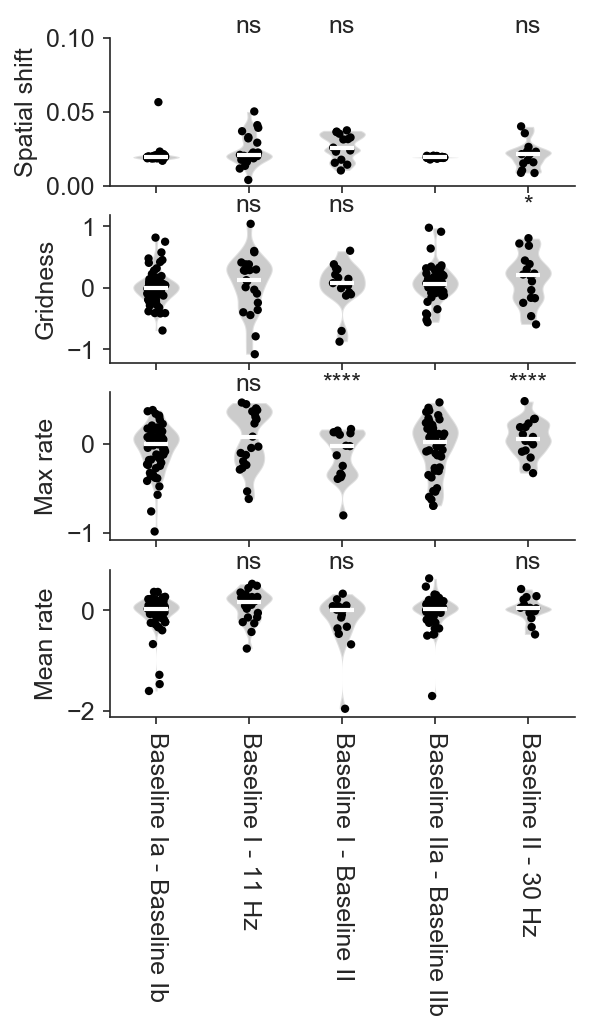

In [223]:
fig, axs = plt.subplots(4, 1, sharex=True)

swarm_violin(results_change, stats, comparison_key_val, 'gridcell', 'xcorr_cntr_mass', ax=axs[0], clip=.1)
axs[0].set_ylabel('Spatial shift')

swarm_violin(results_change, stats, comparison_key_val, 'gridcell', 'gridness', ax=axs[1])
axs[1].set_ylabel('Gridness')

swarm_violin(results_change, stats, comparison_key_val, 'gridcell', 'max_rate', ax=axs[2])
axs[2].set_ylabel('Max rate')

swarm_violin(results_change, stats, comparison_key_val, 'gridcell', 'average_rate',  ax=axs[3])
axs[3].set_ylabel('Mean rate')

plt.xticks([0,1,2,3,4], list(comparison_key_val.keys()), rotation=-90, ha='center')
# # plt.tight_layout()
# fig.savefig(output_path / 'figures' / 'violins_swarm.png', bbox_inches='tight')
# fig.savefig(output_path / 'figures' / 'violins_swarm.svg', bbox_inches='tight')

# paired plotting

In [227]:
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 6), 
    'figure.dpi': 150
})

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


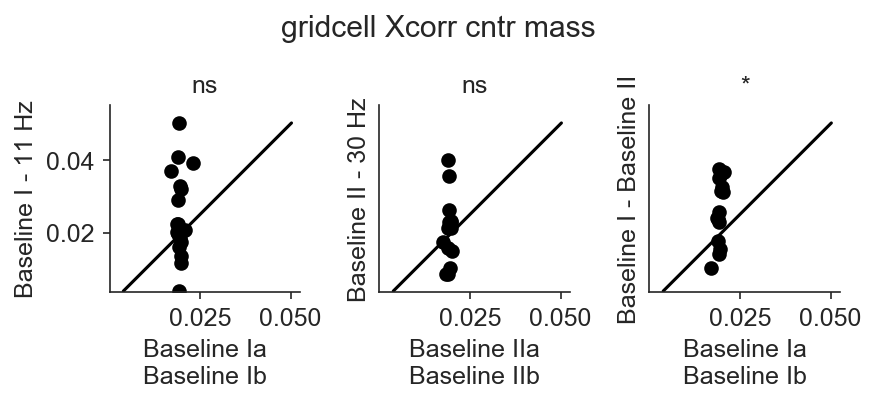

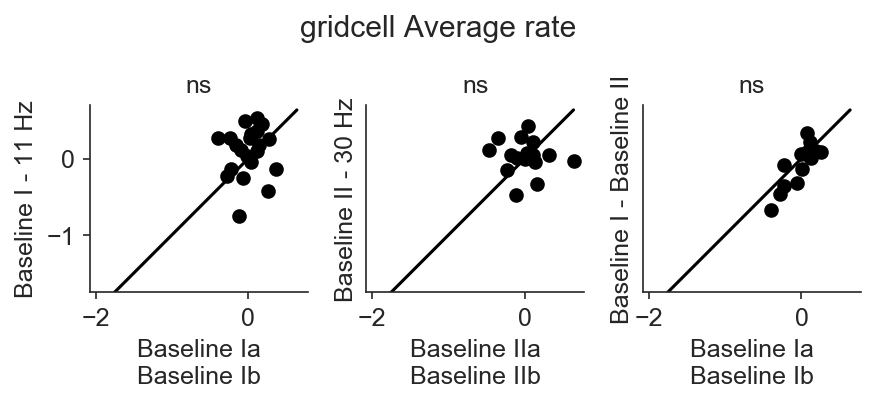

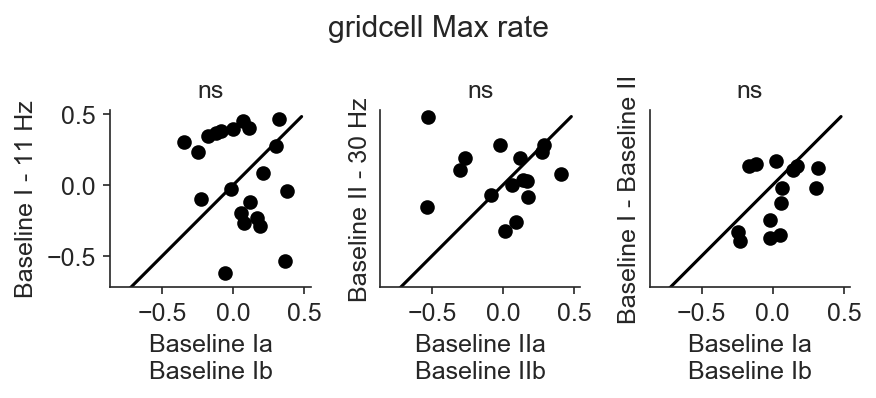

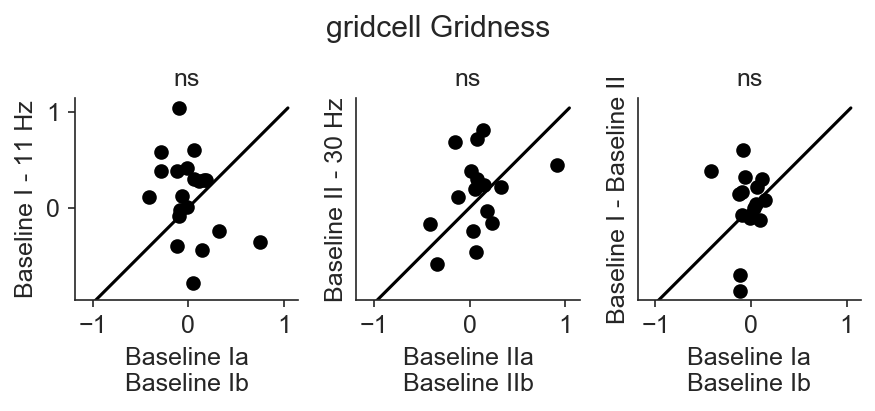

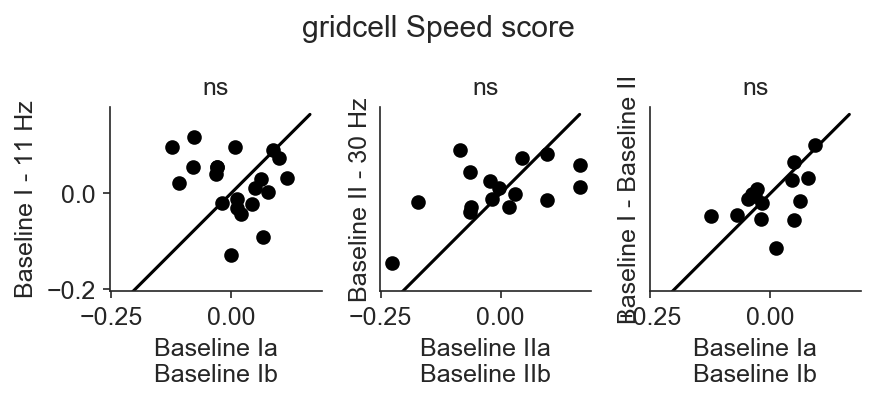

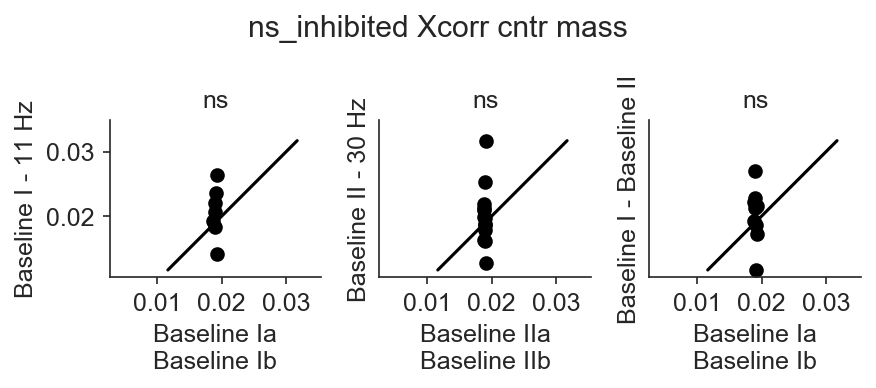

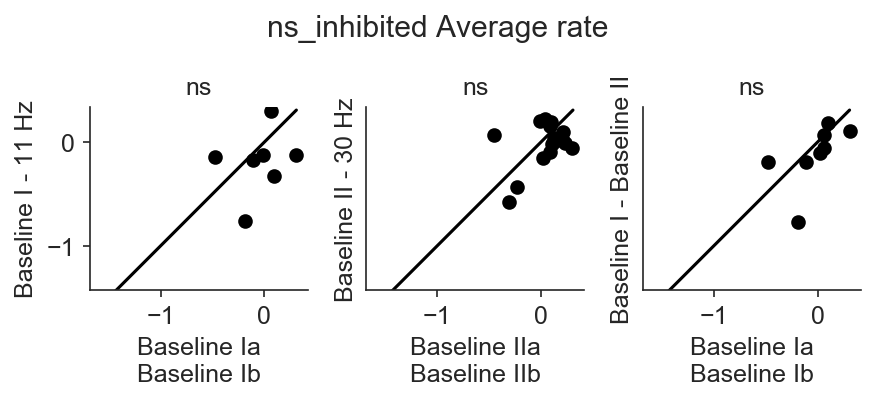

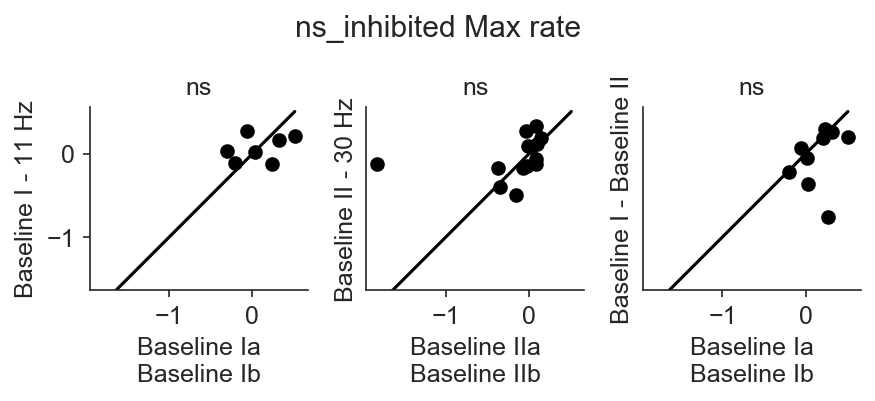

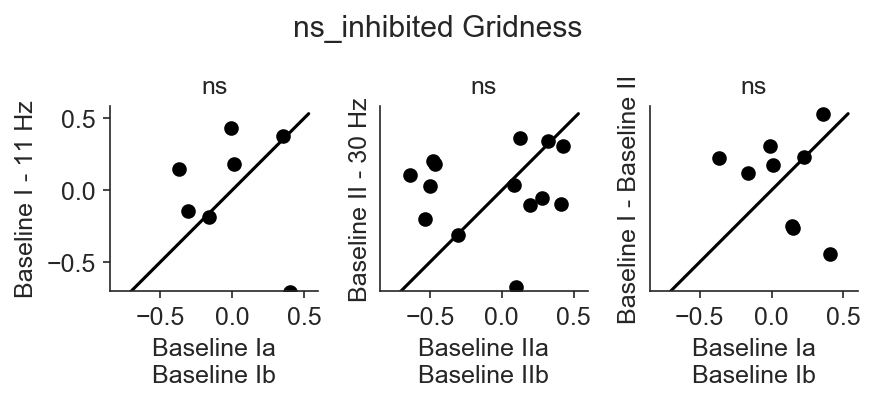

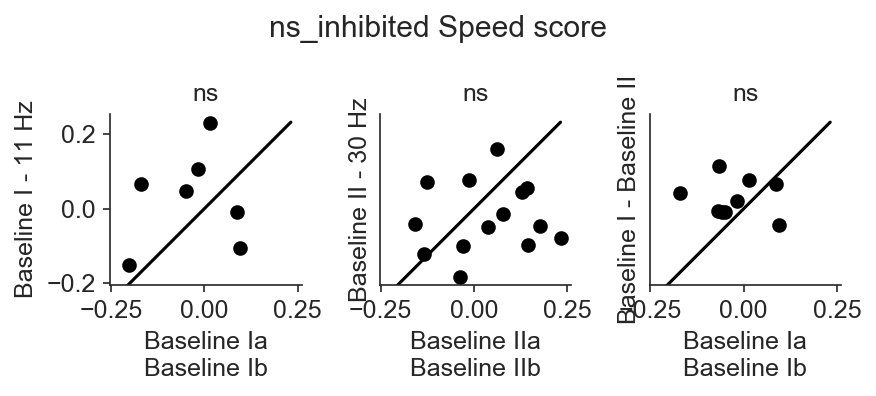

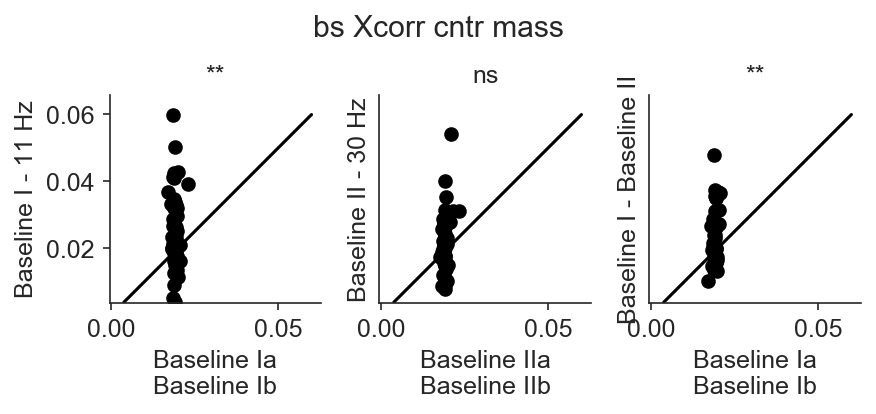

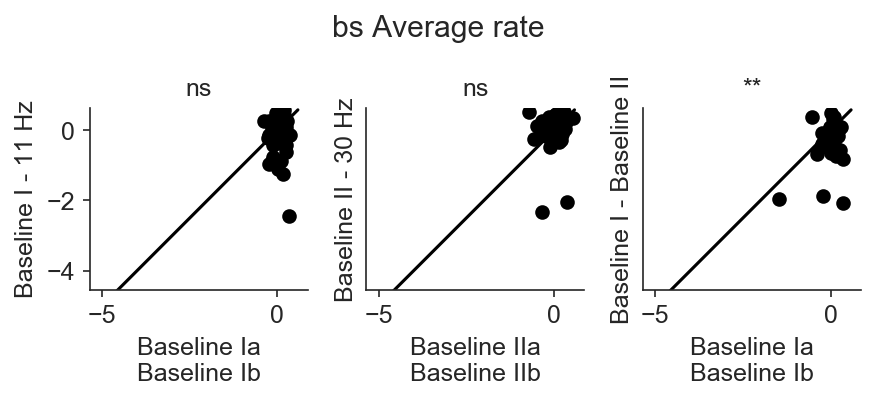

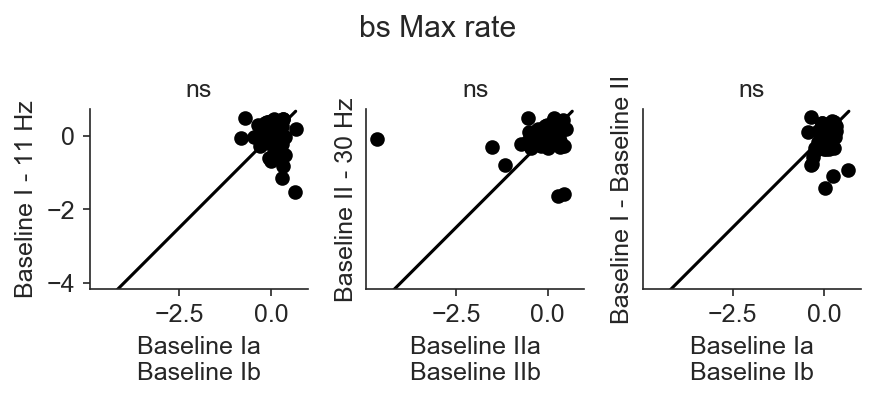

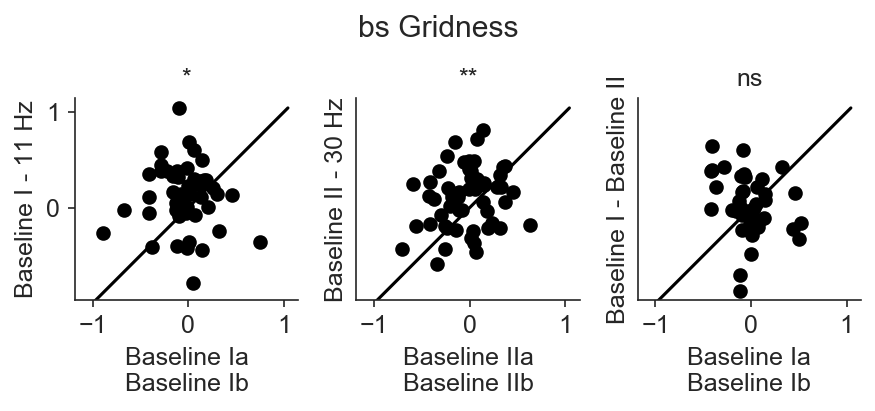

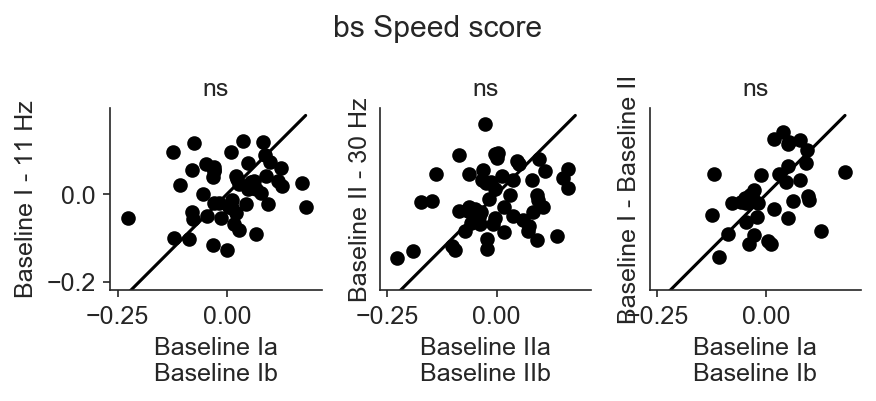

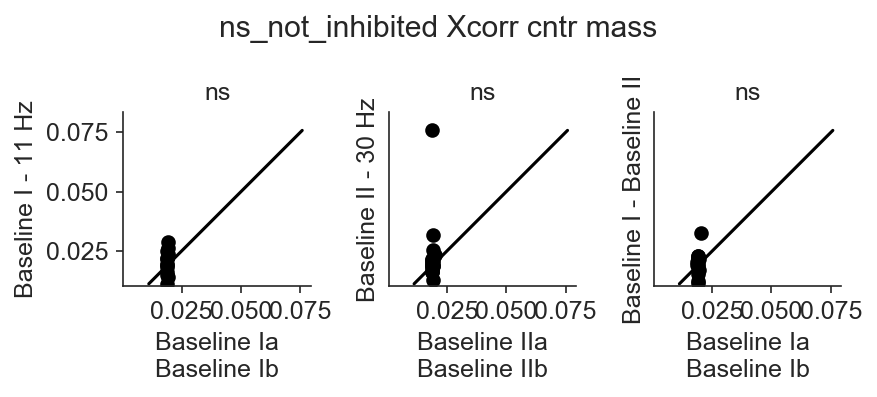

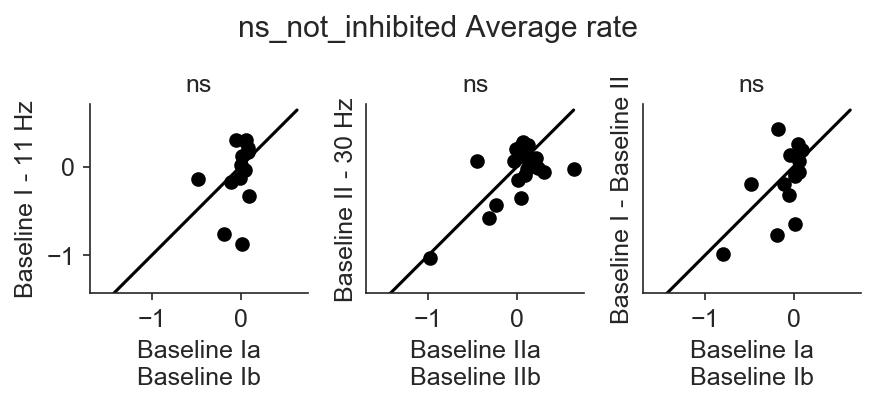

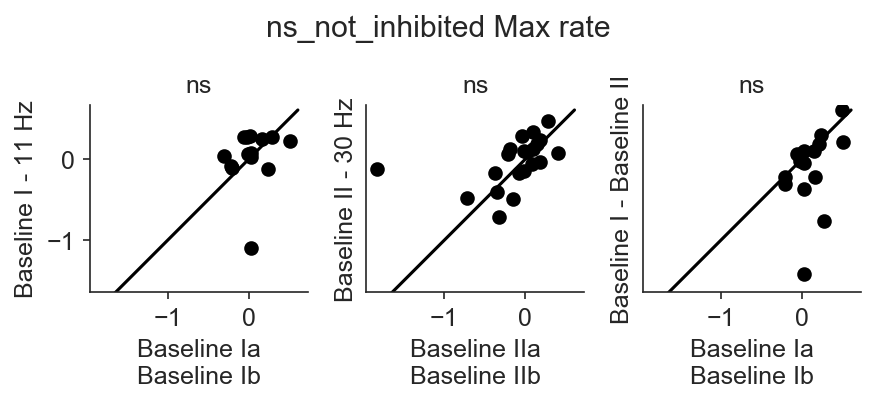

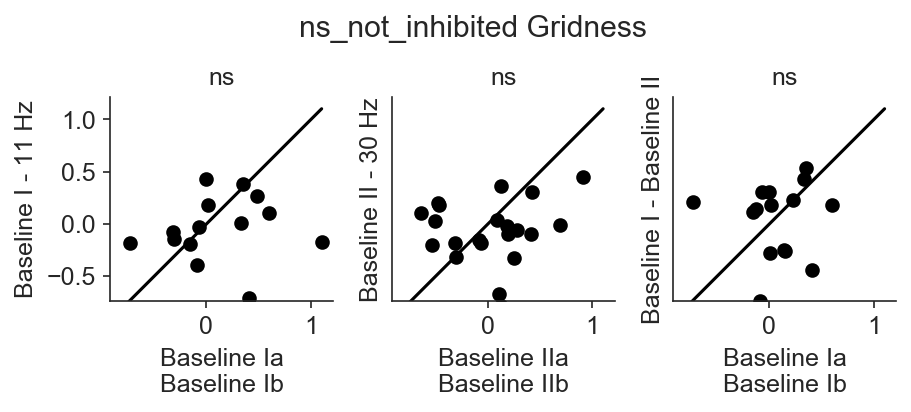

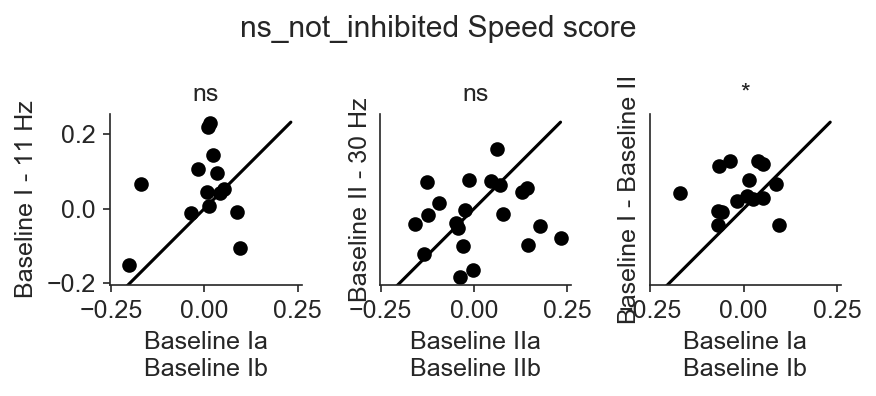

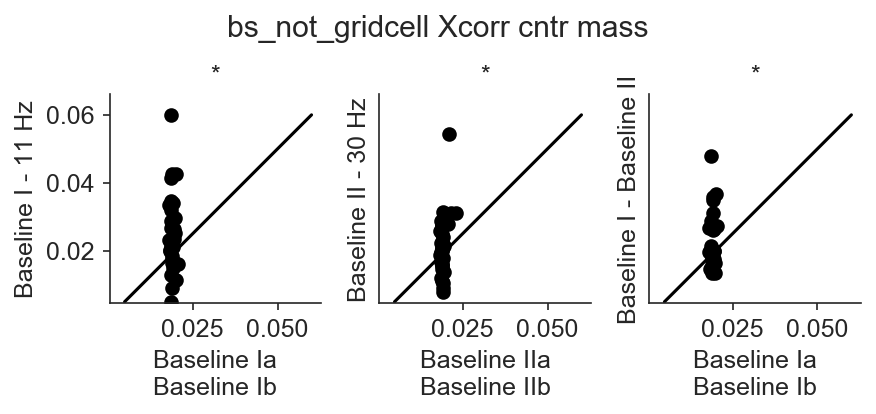

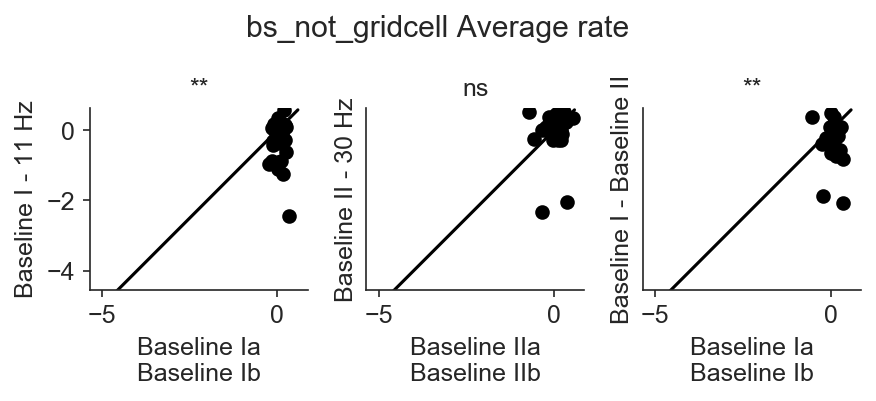

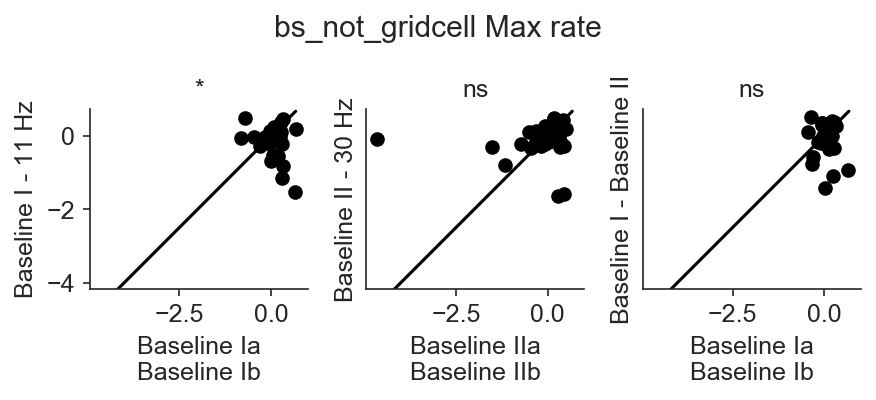

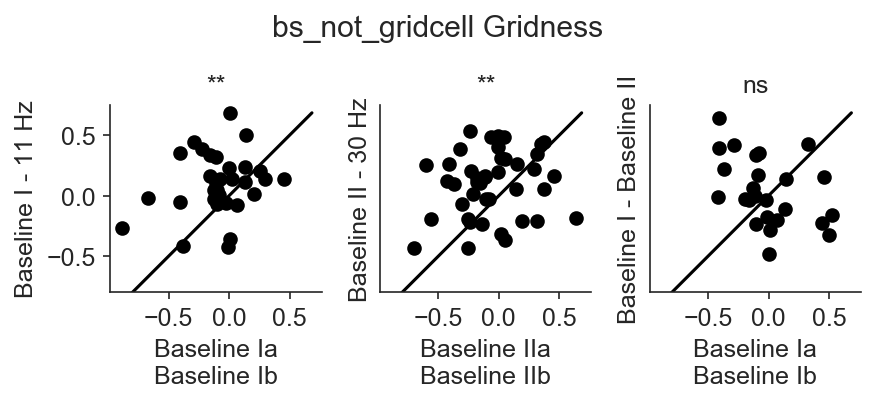

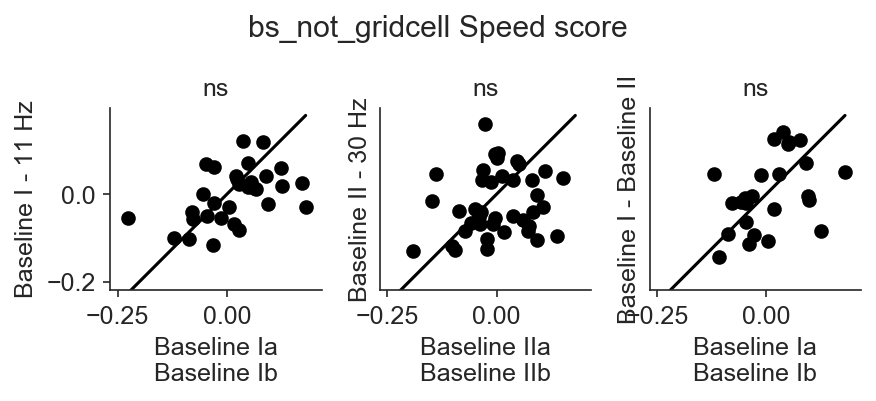

In [233]:
comparisons = [
    ['Baseline Ia - Baseline Ib', 'Baseline I - 11 Hz'],
    ['Baseline IIa - Baseline IIb', 'Baseline II - 30 Hz'],
    ['Baseline Ia - Baseline Ib', 'Baseline I - Baseline II'],
    
]
for cell_type in results_change:
    for key in ['xcorr_cntr_mass', 'average_rate', 'max_rate', 'gridness', 'speed_score']:
        fig, axs = plt.subplots(1, len(comparisons), sharex=True)
        plt.suptitle(cell_type + ' ' + rename(key))
        max_vals = []
        min_vals = []
        y_limits = []
        for ax, comparison in zip(axs, comparisons):
            values = results_change[cell_type][key].loc[:,comparison].replace([np.inf, -np.inf], np.nan).dropna()
            max_vals.append(values.values.max())
            min_vals.append(values.values.min())
            ax.scatter(values[comparison[0]], values[comparison[1]], color='k')
            ax.set_ylabel(comparison[1])
            ax.set_xlabel('\n'.join(comparison[0].split(' - ')))
            # significance
            pvalue = paired_stats_values[cell_type].loc[' - '.join(comparison), key]
            if pvalue < 0.0001:
                significance = "****"
            elif pvalue < 0.001:
                significance = "***"
            elif pvalue < 0.01:
                significance = "**"
            elif pvalue < 0.05:
                significance = "*"
            else:
                significance = "ns"

            ax.set_title(significance)

        max_val = max(max_vals)
        min_val = min(min_vals)
        for i, ax in enumerate(axs):
            ax.set_ylim(min_val - min_val * 0.1, max_val + max_val * 0.1)
            ax.plot([min_val, max_val], [min_val, max_val], color='k')
            ax.set_aspect(1)
            if i > 0:
                despine(yticks=False, ax=ax)
            else:
                despine(ax=ax)
        fig.tight_layout(rect=[0, 0.6, 1, 0.95])
        savefig(output_path / 'figures' / f'pairwise_{cell_type}_{key}')

# Save to expipe

In [50]:
action = project.require_action("longitudinal-comparisons")

In [51]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/statistics/PRS.csv',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/statistics/summary.tex',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/statistics/PRS.tex',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/statistics/MWU.csv',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/statistics/summary.csv',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/statistics/MWU.tex',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/figures/neuron_629_rate_map.svg',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/figures/neuron_150_speed_map.png',
 '/media/storage/expipe/septum-mec/actions/longitudinal-comparisons-gridcells/data/figures/neuron_317_rate_map.png',
 '/media/storage

In [52]:
septum_mec.analysis.registration.store_notebook(action, "20_longitudinal_comparisons.ipynb")